**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
data = pd.read_csv('../data/twit/positive.csv.gz',sep=';',header=None)
data.columns = ff
ppr(data)
data.sample(3)

записей: 114 911


,id,tdate,tmane,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount,unk
55597,410083806779932672,1386606573,alargo3,"@Lubalubochka2 Ты говори о чем нибудь,а дальше о веселом я,если будет получатся:))",1,0,0,0,579,32,107,1
63558,410350229960261632,1386670093,AKPuchkov,RT @fc_textil: Сегодня - всемирный день футбола. С праздником! :),1,0,4,0,713,43,91,0
26319,409575006478536704,1386485265,_alquimica,"RT @daringjay_rina: #HappyBirthdayIanFromRussia хэйхэйхэй\nсегодня же день обаяшки Йена,\nС Днём Рождения,милый ;) http://t.co/n7XEvqbEhR",1,0,9,0,8257,248,113,0


In [6]:
data = data[['id','ttext']]
data.sample(3)

,id,ttext
69303,410410117965037568,"RT @TANIAS_26: @Maerovskaya белый, черный, белый, черный)"
26061,409571288391241728,Вот та самая фотография) я обязательно снова полюблю и обязательно снова буду в этом ангельском… http://t.co/NnOap7vUYX
69900,410464704990285826,"Я просто схожу с ума. Когда я рядом с тобой, я самая счастливая!) крышу сносит просто конкретно!!!) мне это нравится...)"


In [7]:
assert len(data['id']) == len(set(data['id']))

In [8]:
# data.dtypes

## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 114911/114911 [00:00<00:00, 118640.23it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 114911/114911 [00:01<00:00, 94586.71it/s] 


In [12]:
data.sample(3)

,id,ttext,ttext_clean
83460,410775590078136322,"@Just__Fantasy блиа, точно.\nмне и от тебя синяков хватит :D\nоставим Эммета этой сучке Розали\nа лучше я забиру ее :D\nя не хочу Элис","[just, fantasy, блиа, точно, мне, и, от, тебя, синяков, хватит, happysmile, оставим, эммета, этой, сучке, розали, а, лучше, я, забиру, ее, happysmile, я, не, хочу, элис]"
57311,410122552506585088,@MishaKrushnic а ну ка обняли меня дружно! своими ментальными ручонками :D,"[mishakrushnic, а, ну, ка, обняли, меня, дружно, своими, ментальными, ручонками, happysmile]"
74223,410631637638983682,"G-League 2013 Day 3. написал небольшой аннонс-прогноз: http://t.co/R2P78Sb39e , всех жду в 16 по МСК :) #dotasltv #g1league #sltv","[g, league, digit, day, digit, написал, небольшой, аннонс, прогноз, url, всех, жду, в, digit, по, мск, happysmile, dotasltv, sltv]"


In [13]:
# удаление коротких слов
# data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 114 911
записей: 114 911


In [15]:
data.sample(3)

,id,ttext,ttext_clean
96135,411022464592801792,"ФГОСТ второго поколения тоже не выдерживает критики, но мне по барабану, не буду ворчать ;)","[фгост, второго, поколения, тоже, не, выдерживает, критики, но, мне, по, барабану, не, буду, ворчать, happysmile]"
101535,411093561870790656,"@MurzovaBortch не знаю его. И вообще причем тут он,если я пишу про ОмЮА?) понимаешь,что тут СибГУФК никаким боком))","[murzovabortch, не, знаю, его, и, вообще, причем, тут, он, если, я, пишу, про, омюа, понимаешь, что, тут, сибгуфк, никаким, боком, happysmile]"
94962,411007830016425984,"В ""This is us"" нам покажут тяжелые репетиции парней.\nАГА. О ТОМ КАК ОНИ НОСЯТСЯ, ДУРАЧАТСЯ, ОРУТ. ХАХАА :DD Я БЫ ПОСМОТРЕЛА НА ЭТО :D #пиар","[в, this, is, us, нам, покажут, тяжелые, репетиции, парней, ага, о, том, как, они, носятся, дурачатся, орут, хахаа, happysmile, d, я, бы, посмотрела, на, это, happysmile, пиар]"


In [16]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 166 099


In [17]:
# voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
# voc = { w:i+1 for i,w in enumerate(voc) }
# voc['<pad>']= 0
# ppr(voc)

In [18]:
# voc

## кодируем слова

In [19]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 114911/114911 [00:00<00:00, 253424.14it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
37260,"RT @lenismob: http://t.co/2sCNfs9rlU одна сигарета отнимает 15 минут жизни, а один урок 45 минут.=)","[rt, lenismob, url, одна, сигарета, отнимает, digit, минут, жизни, а, один, урок, digit, минут]","[34076, 21953, 41034, 107265, 137505, 110580, 9280, 96245, 73796, 45621, 107203, 153423, 9280, 96245]"
12083,"RT @LovaStuka: Люблю, когда люди такие же ненормальные, как и я ;)","[rt, lovastuka, люблю, когда, люди, такие, же, ненормальные, как, и, я, happysmile]","[34076, 23281, 92708, 85633, 92843, 146299, 73318, 102799, 82759, 79635, 164868, 14801]"
3184,привет @Roxa_ami ! медитируешь?))) да ещё и в темноте!) не страшно ли?,"[привет, roxa, ami, медитируешь, happysmile, да, ещё, и, в, темноте, не, страшно, ли]","[124491, 34011, 1759, 95022, 14801, 66531, 72973, 79635, 55739, 147559, 101792, 144239, 91218]"


In [21]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    114911
mean         13
std           4
min           1
25%          10
50%          13
75%          17
max          42
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

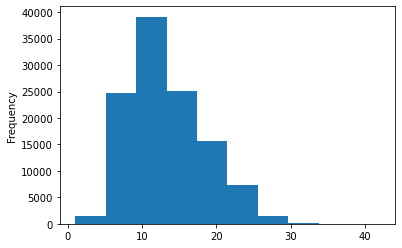

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

42

In [24]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 114911/114911 [00:00<00:00, 342430.78it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    114911
mean         42
std           0
min          42
25%          42
50%          42
75%          42
max          42
Name: code, dtype: int64

## строим датасет

In [26]:
# pair = data[['id','id']]
# pair.columns = ['id_l','id_r']
# pair

In [27]:
pair_neg = pd.DataFrame({
'id_L':data['id'].iloc[:-1].tolist(),
'id_R':data['id'].iloc[1:].tolist()
})

In [28]:
# НЕпохожие пары
pair_neg = pair_neg\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_neg['target'] = 0
ppr(pair_neg)

записей: 114 910


In [29]:
pair_pos = pd.DataFrame({
'id_L':data['id'].tolist(),
'id_R':data['id'].tolist()
})

In [30]:
# похожие пары
pair_pos = pair_pos\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_pos['target'] = 1
ppr(pair_pos)

записей: 114 911


In [31]:
cols = ['id_L','code_L','id_R','code_R','target']
dataset = pd.concat([
        pair_pos[cols],
        pair_neg[cols],
    ],axis=0).reset_index(drop=True)
ppr(dataset)

записей: 229 821


In [32]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((229821, 42), (229821, 42), (229821, 1))

In [33]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [34]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((229821, 42), (229821, 42), (229821, 1), 166099)

In [35]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [36]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

42

In [37]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [38]:
# отделяем тестовый набор
x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((114910, 84), (114910, 1), (114911, 84), (114911, 1))

In [39]:
x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
y_train = y_train.flatten()
x_left_train.shape, x_right_train.shape, y_train.shape

((114910, 42), (114910, 42), (114910,))

In [40]:
x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
y_test = y_test.flatten()
x_left_test.shape, x_right_test.shape, y_test.shape

((114911, 42), (114911, 42), (114911,))

In [41]:
# %xdel x_left
# %xdel x_right
# %xdel target

In [42]:
# gc.collect()

In [43]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [44]:
embed_len = 32
embed_input_dim, embed_len, seq_len

(166099, 32, 42)

In [45]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.4.0', '2.4.0')

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss

In [47]:
from tensorflow import cast

def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean(y * K.square(preds) + (1 - y) * squaredMargin)

$$
y \cdot p^2 + (1 - y) \cdot ( 1-p ) ^2
$$

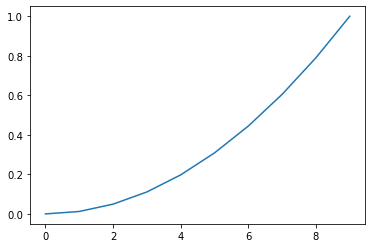

In [48]:
from matplotlib import pyplot as plt

y = np.ones(10)
p = np.linspace(0,1,10)

# y = np.zeros(10)
# p = np.linspace(1,0,10)

# y = np.hstack([np.zeros(10),np.ones(10),])
# p = np.hstack([ np.linspace(1,0,10), np.linspace(0,1,10) ])

plt.plot( y*(p**2) + (1-y)*((1-p)**2) )

In [49]:
embed_input_dim,seq_len,embed_len

(166099, 42, 32)

In [50]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

In [51]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

In [52]:
# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

In [53]:
# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

In [54]:
# классификатор
predictions = Dense(1, activation='sigmoid')(merged)

In [55]:
# создаём модель
model = Model([input_l,input_r], predictions )

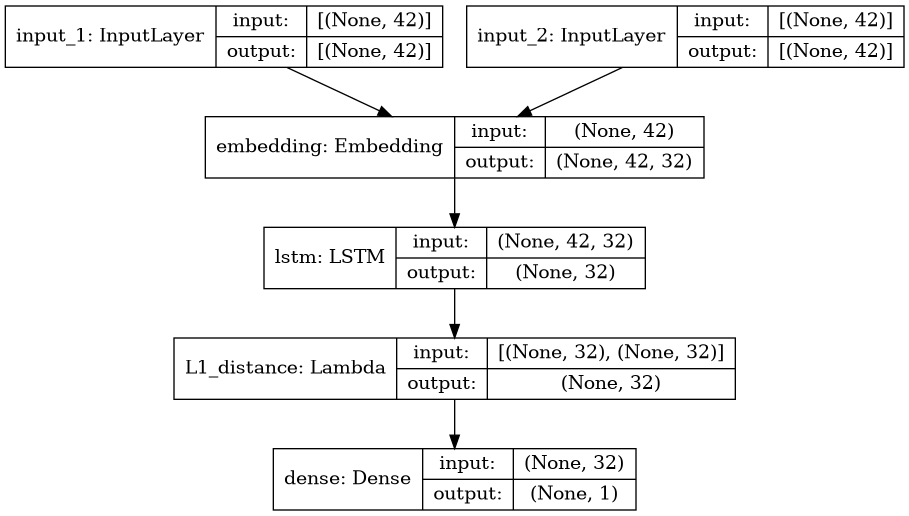

In [56]:
plot_model(model,
           #to_file=pjoin(FOLDER_RESULT,'model-embed-lstm.png'), 
           show_layer_names=True, show_shapes=True )
# model.summary()

In [57]:
learning_rate = 9e-5
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [71]:
%%time

n_epochs = 1

history = model.fit( [x_left_train, x_right_train], y_train,
           epochs = n_epochs,
           batch_size = 4096,
           validation_split=.2,
         )

23/23 [==============================] - 3s 129ms/step - loss: 0.2497 - acc: 0.1834 - val_loss: 0.2494 - val_acc: 0.1077
CPU times: user 5.13 s, sys: 271 ms, total: 5.4 s
Wall time: 3.06 s


----

In [69]:
# plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
# plt.legend()
# plt.grid()

In [70]:
# plt.plot( np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
# plt.legend()
# plt.grid()

In [63]:
# gc.collect()

## тест

In [72]:
# dataset.sample(2)

In [73]:
dataset['dist'] = model.predict([x_left,x_right,])

In [74]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','ttext']].rename(columns={'id':'id_R','ttext':'ttext_R'}),on='id_R')\
    .merge(data[['id','ttext']].rename(columns={'id':'id_L','ttext':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]
data_dist.sample(3)

,ttext_L,ttext_R,dist
206816,Три раза подряд встретить гринвуда именно тогда когда я так не красиво выгляжу),Три раза подряд встретить гринвуда именно тогда когда я так не красиво выгляжу),0.49978
68447,"@Sofya__Styles Да,да)) \nДиржиии О/ http://t.co/HL5kkITamW",@kjulava и в этом нет ничего плохого кстати\nЗато научишься жить одна\nПитаться подножным кормом:D,0.50009
6144,@lerysik1399 @_dashynka_ кто то уже неделю ничего не пишет),@lerysik1399 @_dashynka_ кто то уже неделю ничего не пишет),0.49978


In [75]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,229821.0,0.500384,0.001053,0.495793,0.49978,0.49978,0.500945,0.507331


In [77]:
data_dist[ data_dist['dist'].between(.49,.60) & (data_dist['ttext_L']!=data_dist['ttext_R']) ]

,ttext_L,ttext_R,dist
1,"@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)","Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",0.499397
3,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,0.499904
5,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",0.501577
7,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…","@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",0.499993
9,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6,0.501012
...,...,...,...
229811,"Торт с черносливом :) купленный на кропотке в том магазине, ведь тот же? http://t.co/EB8Z8bOBRZ","Спала в родительском доме, на своей кровати... Проснулась с кошкой на голове))",0.499936
229813,"Спала в родительском доме, на своей кровати... Проснулась с кошкой на голове))","RT @jebesilofyt: Эх... Мы немного решили сократить путь, сейчас уже лежу в мягкой кровати :) а с отсутствием сети помогла справится какая-",0.501228
229815,"RT @jebesilofyt: Эх... Мы немного решили сократить путь, сейчас уже лежу в мягкой кровати :) а с отсутствием сети помогла справится какая-","Что происходит со мной, когда в эфире #proactivefm звучит моя любимая песня)) #dctalk #music @… http://t.co/65KGFFd5oO",0.503524
229817,"Что происходит со мной, когда в эфире #proactivefm звучит моя любимая песня)) #dctalk #music @… http://t.co/65KGFFd5oO","""Любимая,я подарю тебе эту звезду..."" Имя какой звезды переводится ""подмышка""? ;-)",0.501630
